<a href="https://colab.research.google.com/github/christophersingh/Master/blob/main/Intermittent%20Time%20Series%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Created by: Prof. Valdecy Pereira, D.Sc.
# UFF - Universidade Federal Fluminense (Brazil)
# email:  valdecy.pereira@gmail.com
# Lesson: Forecasting - Intermittent Demand
 
# GitHub Repository: <https://github.com/Valdecy>

In [ ]:
# Required Libraries
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd

In [ ]:
# Function: V & Q
def v_q_values(ts):
    v = ts[ts > 0]
    q  = []
    x1 = 1
    for i in range(0, ts.shape[0]):
        if (ts[i] > 0):
            x2 = i+1
            zeros = (ts[x1:x2] == 0).sum(axis = 0)
            if (zeros >= 0):
                q.append(zeros)
                x1 = x2-1
    return v, np.asarray(q)

# Function: Plot TS
def plot_int_demand(ts, test = [], size_x = 10, size_y = 10, prediction = []):
    plt.figure(figsize = (size_x, size_y))
    plt.scatter(ts[ts > 0].index.to_pydatetime(), ts[ts > 0], color = 'k', alpha = 0.7, marker = 's')
    plt.bar(ts[ts > 0].index.to_pydatetime(), ts[ts > 0], width = 4, color = 'purple', alpha = 0.3)
    if (len(test) > 0):
      plt.scatter(test[test > 0].index.to_pydatetime(), test[test > 0], color = 'k', alpha = 0.7, marker = 's')
      plt.bar(test[test > 0].index.to_pydatetime(), test[test > 0], width = 4, color = 'blue', alpha = 0.3)
    if (len(prediction) > 0):
        plt.scatter(prediction[:ts.shape[0]][prediction > 0].index.to_pydatetime(), prediction[:ts.shape[0]][prediction > 0], c = 'orange')
        plt.plot(prediction[:ts.shape[0]].index.to_pydatetime(), prediction[:ts.shape[0]], c = 'red')
        plt.scatter(prediction[ts.shape[0]:][prediction > 0].index.to_pydatetime(), prediction[ts.shape[0]:][prediction > 0], c = 'green')
    return

# Function: MASE (Mean Absolute Scaled Error)
def mase(ts, prediction):
    divisor = 0
    for i in range(1, ts.shape[0]):
        divisor = divisor + abs(ts[i] - ts[i-1])
    divisor = divisor/(ts.shape[0] - 1)
    diff    = abs(ts - prediction[:ts.shape[0]])/divisor
    mase    = diff.mean()
    return mase

# Function: RMSE (Root Mean Squared Error)
def rmse(ts, prediction):
    diff = (ts - prediction[:ts.shape[0]])**2
    mse  = diff.mean()
    return mse**(1/2)

# Function: Croston Method
def croston_method(ts, alpha = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i  = ts.copy(deep = True)
    q_i  = ts.copy(deep = True)
    f_i  = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]  
    q_i[0]        = 1 
    f_i[0]        = v_i[0]/q_i[0]
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = alpha*q[idx_2] + (1 - alpha)*q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = v_i[idx_1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = v_i[idx_1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))    
    return v_i, q_i, f_i

# Function: SBA (Syntetos & Boylan) Method
def sba_method(ts, alpha = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i = ts.copy(deep = True)
    q_i = ts.copy(deep = True)
    f_i = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]  
    q_i[0]        = 1 
    f_i[0]        = v_i[0]/q_i[0]
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = alpha*q[idx_2] + (1 - alpha)*q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = (1 - alpha/(2))*(v_i[idx_1+1]/q_i[idx_1+1])
            else:
                f_i[idx_1+1] = (1 - alpha/(2))*v_i[idx_1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = (1 - alpha/(2))*v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = (1 - alpha/(2))*v_i[idx_1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))    
    return v_i, q_i, f_i

# Function: SBJ (Shale, Boylan & Johnston) Method
def sbj_method(ts, alpha = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i = ts.copy(deep = True)
    q_i = ts.copy(deep = True)
    f_i = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]  
    q_i[0]        = 1 
    f_i[0]        = v_i[0]/q_i[0]
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = alpha*q[idx_2] + (1 - alpha)*q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = (1 - alpha/(2 - alpha))*(v_i[idx_1+1]/q_i[idx_1+1])
            else:
                f_i[idx_1+1] = (1 - alpha/(2 - alpha))*v_i[idx_1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = (1 - alpha/(2 - alpha))*v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = (1 - alpha/(2 - alpha))*v_i[idx_1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))    
    return v_i, q_i, f_i

# Function: TSB (Teunter, Syntetos & Babai) Method
def tsb_method(ts, alpha = 0.1, beta = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i = ts.copy(deep = True)
    q_i = ts.copy(deep = True)
    f_i = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]    
    q_i[0]        = 1 
    f_i[0]        = v_i[0]*q_i[0]
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = beta           + (1 - beta)*q_i[idx_1]
            f_i[idx_1+1] = v_i[idx_1+1]*q_i[idx_1+1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = (1 - beta)*q_i[idx_1]
            f_i[idx_1+1] = v_i[idx_1+1]*q_i[idx_1+1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))  
    return v_i, q_i, f_i

# Function: HES (Prestwich et al. 2014) Method
def hes_method(ts, alpha = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i  = ts.copy(deep = True)
    q_i  = ts.copy(deep = True)
    f_i  = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]  
    q_i[0]        = 1 
    f_i[0]        = v_i[0]/q_i[0]
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = alpha*q[idx_2] + (1 - alpha)*q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = v_i[idx_1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/(q_i[idx_1+1] + alpha*q[idx_2]/2)
            else:
                f_i[idx_1+1] = v_i[idx_1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))    
    return v_i, q_i, f_i

# Function: LES (Linear-Exponential Smoothing) Method http://arxiv.org/abs/1409.1609
def les_method(ts, alpha = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i  = ts.copy(deep = True)
    q_i  = ts.copy(deep = True)
    f_i  = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]  
    q_i[0]        = 1 
    f_i[0]        = v_i[0]/q_i[0]
    idx_1         = 0
    idx_2         = 0
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = alpha*q[idx_2] + (1 - alpha)*q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = v_i[idx_1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = (v_i[idx_1+1]/q_i[idx_1+1]) * (1 -  alpha*q[idx_2]/(2*q_i[idx_1+1]))
            else:
                f_i[idx_1+1] = v_i[idx_1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))    
    return v_i, q_i, f_i

In [ ]:
# Load Dataset
dataset = pd.read_csv('https://github.com/Valdecy/Datasets/raw/master/Forecasting/Dataset-ET-01.txt', sep = '\t')
#dataset = pd.read_csv('https://github.com/Valdecy/Datasets/raw/master/Forecasting/Dataset-ET-02.txt', sep = '\t')
#dataset = pd.read_csv('https://github.com/Valdecy/Datasets/raw/master/Forecasting/Dataset-ET-03.txt', sep = '\t')
#dataset = pd.read_csv('https://github.com/Valdecy/Datasets/raw/master/Forecasting/Dataset-ET-04.txt', sep = '\t')
#dataset = pd.read_csv('https://github.com/Valdecy/Datasets/raw/master/Forecasting/Dataset-ET-05.txt', sep = '\t')
dataset['DATE'] = pd.to_datetime(dataset['DATE']).map(lambda x: x.strftime('%d-%m-%Y'))
dataset

,DATE,M3,PRICE
0,01-07-2021,5,2.655
1,01-07-2021,20,2.655
2,01-07-2021,15,2.655
3,01-06-2021,10,2.655
4,30-12-2020,10,2.660
...,...,...,...
178,15-01-2019,10,2.170
179,15-01-2019,5,2.170
180,01-07-2019,30,2.250
181,01-03-2019,40,2.260


In [ ]:
# Prepare Time Series TS
ts       = dataset['M3'].copy(deep = True)
ts.index = pd.DatetimeIndex(dataset['DATE'])
ts       = ts.sort_index()
ts       = ts[~ts.index.duplicated(keep = 'last')]
ts       = ts.reindex(pd.date_range(ts.index.min(), ts.index.max()), fill_value = 0) #None
ts       = ts.loc[ts[(ts != 0)].first_valid_index():]

print('')
print('Total Number of Observations: ', ts.shape[0])
print('Total Number of Zeros: ', len(ts[ts == 0]))
print('Start Date: ', ts.index[0])
print('End Date: '  , ts.index[-1])
print('')

ts


Total Number of Observations:  737
Total Number of Zeros:  643
Start Date:  2019-01-02 00:00:00
End Date:  2021-01-07 00:00:00



2019-01-02    15
2019-01-03    40
2019-01-04     0
2019-01-05     0
2019-01-06     0
              ..
2021-01-03     0
2021-01-04     0
2021-01-05     0
2021-01-06    10
2021-01-07     5
Freq: D, Name: M3, Length: 737, dtype: int64

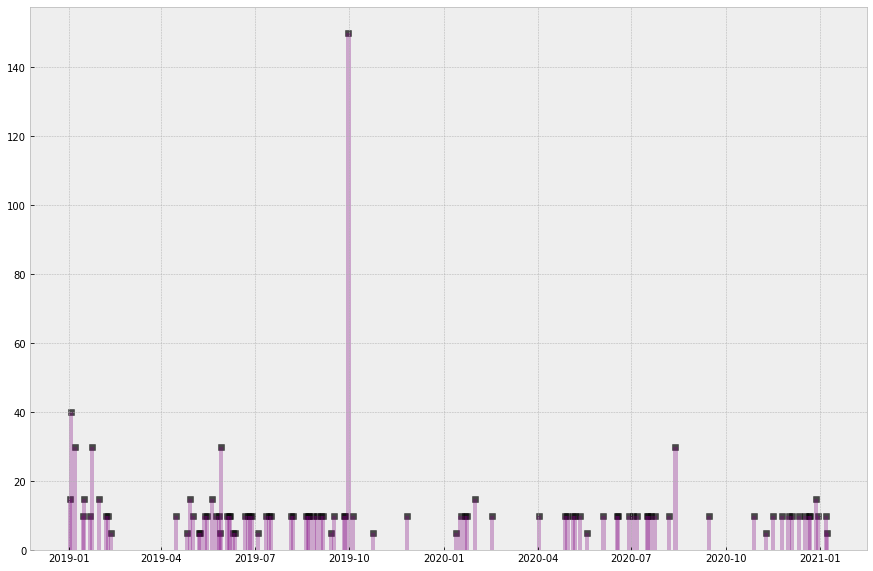

In [ ]:
# Plot Time Series
plot_int_demand(ts, size_x = 15, size_y = 10)

In [ ]:
# Remove Outliers
ts = ts[(ts < 40)]

In [ ]:
# Classification
v, q = v_q_values(ts)
adi  = sum(q)/len(v)
cv   = ( sum( ( (v - ts.mean() )**2)/ len(ts) )/ ts.mean() )**(1/2)

f_type = 'Smooth'
if (adi > 1.32 and cv < 0.49 ):
  f_type = 'Intermittent'
elif (adi > 1.32 and cv > 0.49 ):
  f_type = 'Lumpy'
elif (adi < 1.32 and cv > 0.49 ):
  f_type = 'Erratic'
print('ADI: ', round(adi, 3), ', CV: ', round(cv, 3), ', Type: ', f_type)

ADI:  6.989 , CV:  3.195 , Type:  Lumpy


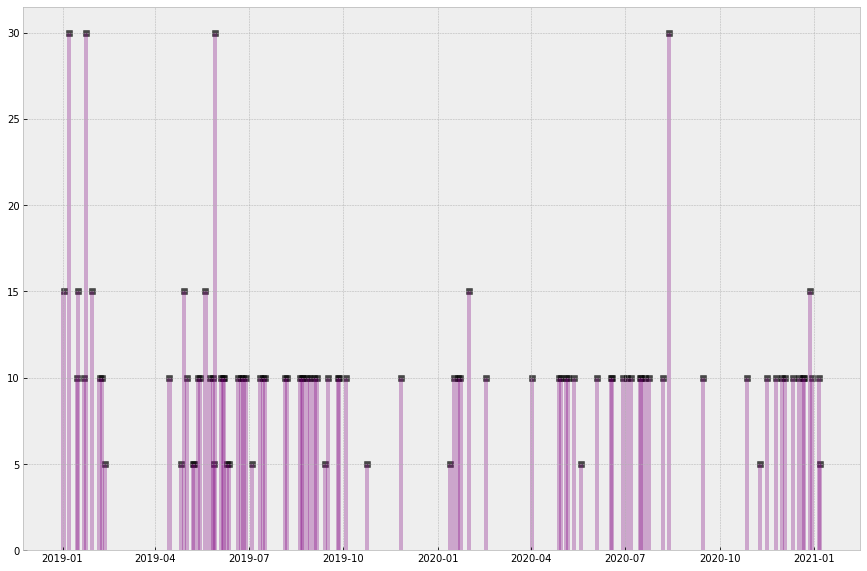

In [ ]:
# Plot Time Series
plot_int_demand(ts, size_x = 15, size_y = 10)

In [ ]:
# One Step Ahead Validation - https://otexts.com/fpp3/tscv.html

In [ ]:
# Croston Method - One Step Ahead Validation
best_alpha = 0
best_error = float('+inf')
for alpha in range(0, 11):
  error_ts  = []
  error_fi  = []
  for i in range (7, len(ts)-1):
    ts_train = ts[0:i]
    ts_test  = ts[i:i+1]
    v_i, q_i, f_i = croston_method(ts_train, alpha = alpha/10, n_steps = 2)
    error_ts.append(ts[i])
    error_fi.append(f_i[-1])
  error_mase = mase(np.array(error_ts), np.array(error_fi))
  print('MASE One Step Ahead: ' , round(error_mase , 3), ', Alpha: ', alpha/10)
  if (error_mase <= best_error):
    best_error = error_mase
    best_alpha = alpha/10
print('')
print('Minimum MASE: ', best_error, ', Best Alpha: ', best_alpha)

MASE One Step Ahead:  6.101 , Alpha:  0.0
MASE One Step Ahead:  1.845 , Alpha:  0.1
MASE One Step Ahead:  1.644 , Alpha:  0.2
MASE One Step Ahead:  1.333 , Alpha:  0.3
MASE One Step Ahead:  1.352 , Alpha:  0.4
MASE One Step Ahead:  1.325 , Alpha:  0.5
MASE One Step Ahead:  1.468 , Alpha:  0.6
MASE One Step Ahead:  1.473 , Alpha:  0.7
MASE One Step Ahead:  1.659 , Alpha:  0.8
MASE One Step Ahead:  1.697 , Alpha:  0.9
MASE One Step Ahead:  1.686 , Alpha:  1.0


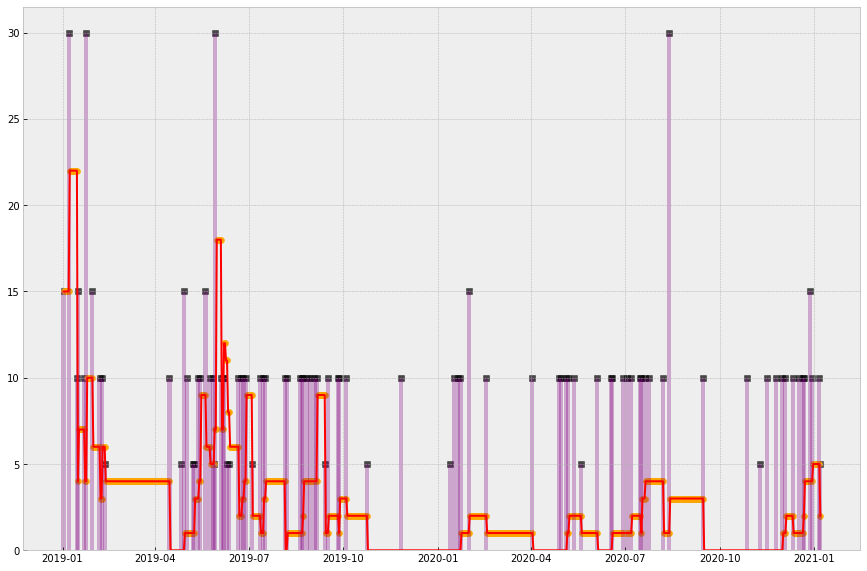

In [ ]:
# Croston Method - Best Model
v_i, q_i, f_i = croston_method(ts, alpha = best_alpha)
plot_int_demand(ts, size_x = 15, size_y = 10, prediction = f_i)

In [ ]:
# SBA Method - One Step Ahead Validation
best_alpha = 0
best_error = float('+inf')
for alpha in range(0, 11):
  error_ts  = []
  error_fi  = []
  for i in range (7, len(ts)-1):
    ts_train = ts[0:i]
    ts_test  = ts[i:i+1]
    v_i, q_i, f_i = sba_method(ts_train, alpha = alpha/10, n_steps = 2)
    error_ts.append(ts[i])
    error_fi.append(f_i[-1])
  error_mase = mase(np.array(error_ts), np.array(error_fi))
  print('MASE One Step Ahead: ' , round(error_mase , 3), ', Alpha: ', alpha/10)
  if (error_mase <= best_error):
    best_error = error_mase
    best_alpha = alpha/10
print('')
print('Minimum MASE: ', best_error, ', Best Alpha: ', best_alpha)

MASE One Step Ahead:  6.101 , Alpha:  0.0
MASE One Step Ahead:  1.662 , Alpha:  0.1
MASE One Step Ahead:  1.435 , Alpha:  0.2
MASE One Step Ahead:  1.114 , Alpha:  0.3
MASE One Step Ahead:  1.115 , Alpha:  0.4
MASE One Step Ahead:  1.062 , Alpha:  0.5
MASE One Step Ahead:  1.129 , Alpha:  0.6
MASE One Step Ahead:  1.013 , Alpha:  0.7
MASE One Step Ahead:  1.109 , Alpha:  0.8
MASE One Step Ahead:  1.033 , Alpha:  0.9
MASE One Step Ahead:  1.063 , Alpha:  1.0

Minimum MASE:  1.013149931224209 , Best Alpha:  0.7


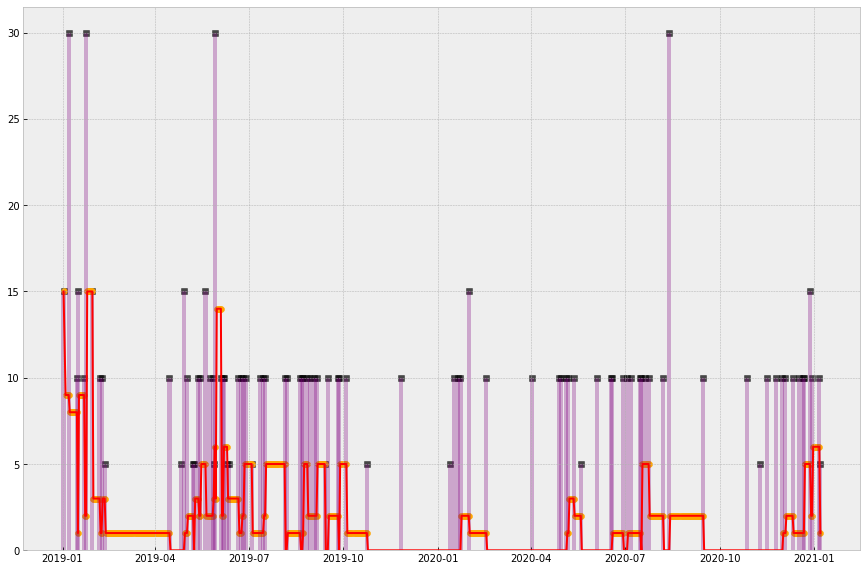

In [ ]:
# SBA Method - Best Model
v_i, q_i, f_i = sba_method(ts, alpha = best_alpha)
plot_int_demand(ts, size_x = 15, size_y = 10, prediction = f_i)

In [ ]:
# SBJ Method - One Step Ahead Validation
best_alpha = 0
best_error = float('+inf')
for alpha in range(0, 11):
  error_ts  = []
  error_fi  = []
  for i in range (7, len(ts)-1):
    ts_train = ts[0:i]
    ts_test  = ts[i:i+1]
    v_i, q_i, f_i = sbj_method(ts_train, alpha = alpha/10, n_steps = 2)
    error_ts.append(ts[i])
    error_fi.append(f_i[-1])
  error_mase = mase(np.array(error_ts), np.array(error_fi))
  print('MASE One Step Ahead: ' , round(error_mase , 3), ', Alpha: ', alpha/10)
  if (error_mase <= best_error):
    best_error = error_mase
    best_alpha = alpha/10
print('')
print('Minimum MASE: ', best_error, ', Best Alpha: ', best_alpha)

MASE One Step Ahead:  6.101 , Alpha:  0.0
MASE One Step Ahead:  1.662 , Alpha:  0.1
MASE One Step Ahead:  1.407 , Alpha:  0.2
MASE One Step Ahead:  1.105 , Alpha:  0.3
MASE One Step Ahead:  1.102 , Alpha:  0.4
MASE One Step Ahead:  0.996 , Alpha:  0.5
MASE One Step Ahead:  1.016 , Alpha:  0.6
MASE One Step Ahead:  0.9 , Alpha:  0.7
MASE One Step Ahead:  0.773 , Alpha:  0.8
MASE One Step Ahead:  0.624 , Alpha:  0.9
MASE One Step Ahead:  0.554 , Alpha:  1.0

Minimum MASE:  0.5537826685006877 , Best Alpha:  1.0


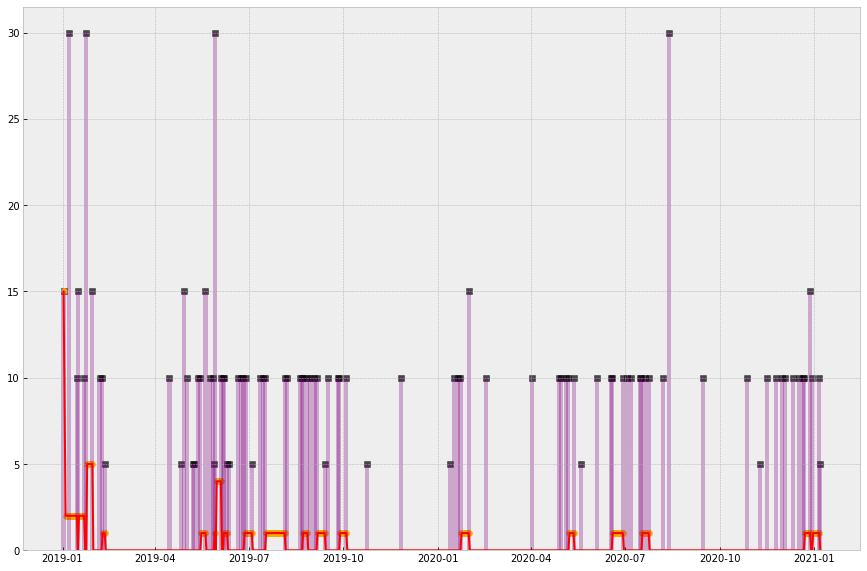

In [ ]:
# SBJ Method - Best Model
v_i, q_i, f_i = sbj_method(ts, alpha = best_alpha)
plot_int_demand(ts, size_x = 15, size_y = 10, prediction = f_i)

In [ ]:
# HES Method - One Step Ahead Validation
best_alpha = 0
best_error = float('+inf')
for alpha in range(0, 11):
  error_ts  = []
  error_fi  = []
  for i in range (7, len(ts)-1):
    ts_train = ts[0:i]
    ts_test  = ts[i:i+1]
    v_i, q_i, f_i = hes_method(ts_train, alpha = alpha/10, n_steps = 2)
    error_ts.append(ts[i])
    error_fi.append(f_i[-1])
  error_mase = mase(np.array(error_ts), np.array(error_fi))
  print('MASE One Step Ahead: ' , round(error_mase , 3), ', Alpha: ', alpha/10)
  if (error_mase <= best_error):
    best_error = error_mase
    best_alpha = alpha/10
print('')
print('Minimum MASE: ', best_error, ', Best Alpha: ', best_alpha)

MASE One Step Ahead:  6.101 , Alpha:  0.0
MASE One Step Ahead:  1.721 , Alpha:  0.1
MASE One Step Ahead:  1.443 , Alpha:  0.2
MASE One Step Ahead:  1.213 , Alpha:  0.3
MASE One Step Ahead:  1.168 , Alpha:  0.4
MASE One Step Ahead:  1.133 , Alpha:  0.5
MASE One Step Ahead:  1.22 , Alpha:  0.6
MASE One Step Ahead:  1.227 , Alpha:  0.7
MASE One Step Ahead:  1.327 , Alpha:  0.8
MASE One Step Ahead:  1.338 , Alpha:  0.9
MASE One Step Ahead:  1.376 , Alpha:  1.0

Minimum MASE:  1.132984869325997 , Best Alpha:  0.5


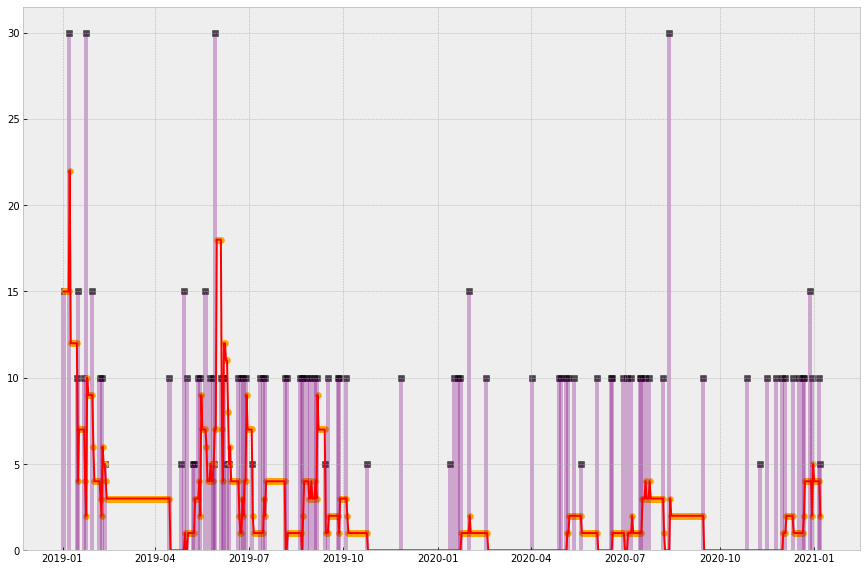

In [ ]:
# HES Method - Best Model
v_i, q_i, f_i = hes_method(ts, alpha = best_alpha)
plot_int_demand(ts, size_x = 15, size_y = 10, prediction = f_i)

In [ ]:
# LES Method - One Step Ahead Validation
best_alpha = 0
best_error = float('+inf')
for alpha in range(0, 11):
  error_ts  = []
  error_fi  = []
  for i in range (7, len(ts)-1):
    ts_train = ts[0:i]
    ts_test  = ts[i:i+1]
    v_i, q_i, f_i = les_method(ts_train, alpha = alpha/10, n_steps = 2)
    error_ts.append(ts[i])
    error_fi.append(f_i[-1])
  error_mase = mase(np.array(error_ts), np.array(error_fi))
  print('MASE One Step Ahead: ' , round(error_mase , 3), ', Alpha: ', alpha/10)
  if (error_mase <= best_error):
    best_error = error_mase
    best_alpha = alpha/10
print('')
print('Minimum MASE: ', best_error, ', Best Alpha: ', best_alpha)

MASE One Step Ahead:  6.101 , Alpha:  0.0
MASE One Step Ahead:  1.654 , Alpha:  0.1
MASE One Step Ahead:  1.397 , Alpha:  0.2
MASE One Step Ahead:  1.184 , Alpha:  0.3
MASE One Step Ahead:  1.132 , Alpha:  0.4
MASE One Step Ahead:  1.078 , Alpha:  0.5
MASE One Step Ahead:  1.164 , Alpha:  0.6
MASE One Step Ahead:  1.14 , Alpha:  0.7
MASE One Step Ahead:  1.171 , Alpha:  0.8
MASE One Step Ahead:  1.135 , Alpha:  0.9
MASE One Step Ahead:  1.275 , Alpha:  1.0

Minimum MASE:  1.0779092159559833 , Best Alpha:  0.5


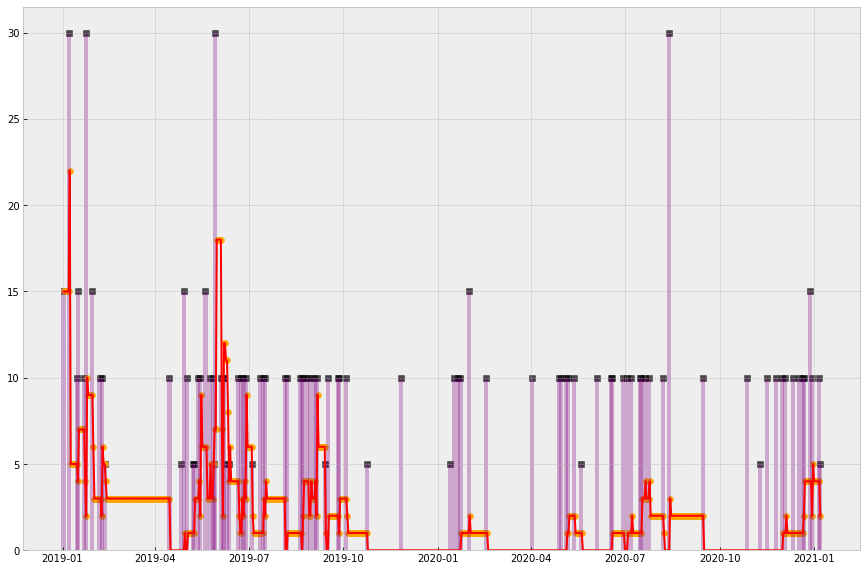

In [ ]:
# LES Method - Best Model
v_i, q_i, f_i = les_method(ts, alpha = best_alpha)
plot_int_demand(ts, size_x = 15, size_y = 10, prediction = f_i)

In [ ]:
# TSB Method
best_alpha = 0
best_beta  = 0
best_error = float('+inf')
for beta in range(0, 2):
  for alpha in range(0, 11):
    error_ts  = []
    error_fi  = []
    for i in range (7, len(ts)-1):
      ts_train = ts[0:i]
      ts_test  = ts[i:i+1]
      v_i, q_i, f_i = tsb_method(ts_train, alpha = alpha/10, beta = beta/10, n_steps = 2)
      error_ts.append(ts[i])
      error_fi.append(f_i[-1])
    error_mase = mase(np.array(error_ts), np.array(error_fi))
    print('MASE One Step Ahead: ' , round(error_mase , 3), ', Alpha: ', alpha/10, ', Beta: ', beta/10)
    if (error_mase <= best_error):
      best_error = error_mase
      best_alpha = alpha/10
      best_beta  = beta/10
print('')
print('Minimum MASE: ', best_error, ', Best Alpha: ', best_alpha, ', Best Beta: ', best_beta)

MASE One Step Ahead:  6.101 , Alpha:  0.0 , Beta:  0.0
MASE One Step Ahead:  2.945 , Alpha:  0.1 , Beta:  0.0
MASE One Step Ahead:  3.339 , Alpha:  0.2 , Beta:  0.0
MASE One Step Ahead:  3.593 , Alpha:  0.3 , Beta:  0.0
MASE One Step Ahead:  3.83 , Alpha:  0.4 , Beta:  0.0
MASE One Step Ahead:  4.111 , Alpha:  0.5 , Beta:  0.0
MASE One Step Ahead:  4.036 , Alpha:  0.6 , Beta:  0.0
MASE One Step Ahead:  4.019 , Alpha:  0.7 , Beta:  0.0
MASE One Step Ahead:  4.114 , Alpha:  0.8 , Beta:  0.0
MASE One Step Ahead:  4.076 , Alpha:  0.9 , Beta:  0.0
MASE One Step Ahead:  4.285 , Alpha:  1.0 , Beta:  0.0
MASE One Step Ahead:  0.554 , Alpha:  0.0 , Beta:  0.1
MASE One Step Ahead:  0.554 , Alpha:  0.1 , Beta:  0.1
MASE One Step Ahead:  0.554 , Alpha:  0.2 , Beta:  0.1
MASE One Step Ahead:  0.554 , Alpha:  0.3 , Beta:  0.1
MASE One Step Ahead:  0.554 , Alpha:  0.4 , Beta:  0.1
MASE One Step Ahead:  0.554 , Alpha:  0.5 , Beta:  0.1
MASE One Step Ahead:  0.554 , Alpha:  0.6 , Beta:  0.1
MASE One St

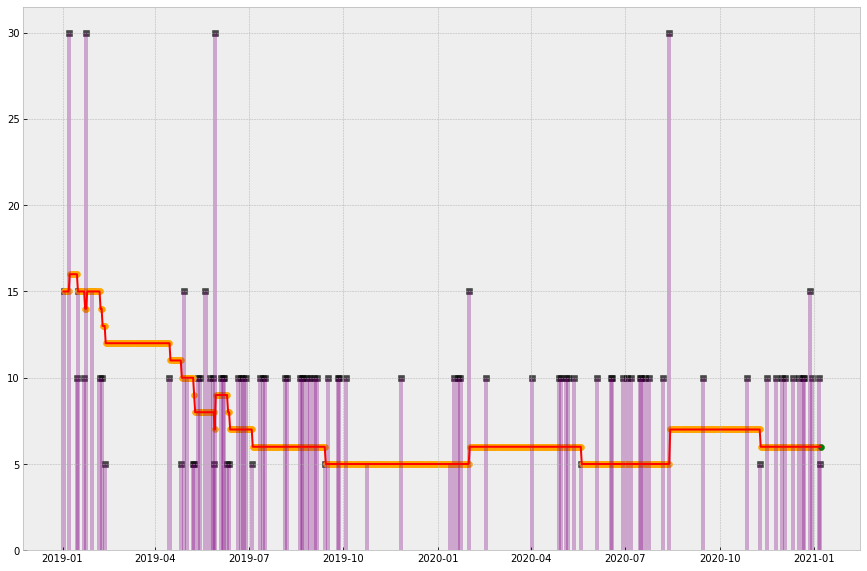

In [ ]:
# TSB Method - Best Model
v_i, q_i, f_i = tsb_method(ts, alpha = best_alpha, beta = best_beta, n_steps = 2)
plot_int_demand(ts, size_x = 15, size_y = 10, prediction = f_i)